Please skip the first two boxes, they are just setup

In [1]:
import sys
sys.path.append('../../lib/')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
from scipy.stats import linregress
from jax.example_libraries.optimizers import adamax, pack_optimizer_state, unpack_optimizer_state
from hetero_simulation.archive.agent import ces_utility, log_utility
from hetero_simulation.ml.utils import *
from hetero_simulation.econ_models.krusell_smith_discrete import neural_network, prices, fischer_burmeister, next_state, batch_loss, simulate_state_forward, training_loop
from hetero_simulation.econ_models.krusell_smith_discrete import params0, config, n, mb, k, m, nn_shapes, generate_random_state, n_forward, n_epoch

jax.config.update('jax_platform_name', 'cpu')

In [2]:
def get_ws(params, config, Xs, Zs, Es):
    Rs, Ws = jax.vmap(prices, in_axes=(None, 0, 0, 0))(config, Xs, Zs, Es)
    return jax.vmap(lambda R, W, X, E: jax.vmap(lambda x, e: (R * x) + (W * e))(X, E))(Rs, Ws, Xs, Es)


def load_model(save_location):
    saved_state = pickle.load(open(save_location, 'rb'))
    opt_state = pack_optimizer_state(saved_state)
    _, _, get_params = adamax(step_size=0.01)
    params = get_params(opt_state)
    key = jax.random.PRNGKey(np.random.randint(1, int(1e8)))
    Xs, Zs, Es, key = generate_random_state(params, config, key, n_forward=100)
    return params, Xs, Zs, Es, key


def plot_loss(params, config, Xs, Zs, Es, key):
    keys = jax.random.split(key, Xs.shape[0])
    u = log_utility()

    Z1s, E1s = jax.vmap(next_state, in_axes=(0, 0, None, 0))(Zs, Es, config, keys)
    Rs, Ws = jax.vmap(lambda X, Z, E: prices(config, X, Z, E))(Xs, Zs, Es)
    ws = jax.vmap(lambda X, E, R, W: jax.vmap(lambda x, e: (R * x) + (W * e))(X, E))(Xs, Es, Rs, Ws)
    outputs = jax.vmap(lambda X, Z, E, w: jax.vmap(lambda i: neural_network(params, X, E, Z, E[i], w[i]))(jnp.arange(k)))(Xs, Zs, Es, ws)
    cs = outputs[..., 0]
    lms = outputs[..., 1]
    c_rels = cs / ws
    X1s = ws - cs
    R1s, W1s = jax.vmap(lambda X, Z, E: prices(config, X, Z, E))(X1s, Z1s, E1s)
    w1s = jax.vmap(lambda X, E, R, W: jax.vmap(lambda x, e: (R * x) + (W * e))(X, E))(X1s, E1s, R1s, W1s)
    c1s = jax.vmap(lambda X, Z, E, w: jax.vmap(lambda i: neural_network(params, X, E, Z, E[i], w[i])[0])(jnp.arange(k)))(X1s, Z1s, E1s, w1s)

    u = lambda c: log_utility()(c)
    gs = jax.vmap(lambda R, cs: jax.vmap(lambda c: config['beta'] * R * jax.grad(u)(c))(cs))(R1s, c1s)
    ups = jax.grad(u)(cs)
    us = jax.vmap(jax.vmap(u))(cs)

    g_diff = (jax.vmap(lambda g, up, lm: (g/up - lm))(gs.reshape(-1, 1), ups.reshape(-1, 1), lms.reshape(-1, 1)))**2

    df = pd.DataFrame(jnp.concatenate([ws.reshape(-1, 1), jnp.repeat(Zs, k).reshape(-1, 1), Es.reshape(-1, 1), 
                                       w1s.reshape(-1, 1),
                                       gs.reshape(-1, 1), c_rels.reshape(-1, 1),
                                       cs.reshape(-1, 1), us.reshape(-1, 1), ups.reshape(-1, 1),
                                       g_diff.reshape(-1, 1), lms.reshape(-1, 1)], axis=1))
    df.columns = ['x', 'Z', 'e', 'x_prime', 'g', 'c_star_rel', 'c_star', 'u', 'u_prime', 'g_diff', 'lms']

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    df['gf'] = df['g'] - df['u_prime']
    df.plot(x='x', y='u_prime', kind='scatter', color='black', ax=axes[0])
    df.plot(x='x', y='g', kind='scatter', color='red', ax=axes[0])
    df.plot(x='x', y='g_diff', kind='scatter', color='black', ax=axes[1])

    _ = fig.suptitle(f'Model evaluation criteria', fontsize=16)
    _ = axes[0].set_title('Euler equation')
    _ = axes[1].set_title('Loss function')
    _ = axes[0].legend(labels=['Marginal Utility (t)', 'Marginal Utility (t+1)'])
    _ = axes[1].legend(labels=['Euler Residual', 'Fischer-Burmeister'])
    
    
def plot_consumption(params, config, Xs, Zs, Es):
    ws = get_ws(params, config, Xs, Zs, Es)
    es = Es[:, 0]

    x_range = jnp.linspace(0, jnp.max(ws), 100)
    c_range = jax.vmap(lambda X, E, Z, e: jax.vmap(lambda x: neural_network(params, X, E, Z, e, x)[0])(x_range))(Xs, Zs, Es, es)
    data = pd.DataFrame(jnp.concatenate((x_range.reshape(-1, 1), c_range.T), axis=1))

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    _ = data.plot(x=0, y=jnp.arange(Xs.shape[0]) + 1, ax=ax, legend=False)
    _ = fig.suptitle(f'Optimal consumption (as a function of idiosyncratic state) across some aggregate states drawn from the ergodic distribution', fontsize=16)

    
def plot_wealth_dist(params, config, Xs, Zs, Es):
    ws = get_ws(params, config, Xs, Zs, Es)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    _ = pd.DataFrame(ws.reshape(-1, 1)).hist(ax=ax, bins=20)
    _ = fig.suptitle(f'Empirical distribution of individual agents\' assets', fontsize=16)
    
    
def simulate_states(params, config, n_periods, Xs, Zs, Es, key):
    X_range = Xs[jnp.newaxis, ...]
    Z_range = Zs[jnp.newaxis, ...]
    E_range = Es[jnp.newaxis, ...]
    for i in range(n_periods - 1):
        Xs, Zs, Es, key = simulate_state_forward(params, config, Xs, Zs, Es, key, 1)
        X_range = jnp.concatenate((X_range, Xs[jnp.newaxis, ...]))
        Z_range = jnp.concatenate((Z_range, Zs[jnp.newaxis, ...]))
        E_range = jnp.concatenate((E_range, Es[jnp.newaxis, ...]))

    states = pd.DataFrame(jnp.concatenate((X_range[:, 1, :], Z_range[:, 1][:, jnp.newaxis], E_range[:, 1, :]), axis=1))
    agg_states = pd.DataFrame(jnp.sum(X_range[:, 1, :], axis=1))
    states = pd.concat((states, agg_states), axis=1)
    states.columns = [f'Agent {i+1} Assets' for i in range(k)] +\
                     [f'Aggregate Productivity'] +\
                     [f'Agent {i+1} Employment' for i in range(k)] +\
                     ['Total Assets in Economy']
    states['Total Employment'] = states[[f'Agent {i + 1} Employment' for i in range(k)]].sum(axis=1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    _ = states.plot(y=[f'Agent {i+1} Assets' for i in range(k)], ax=axes[0])
    _ = states.plot(y=['Total Assets in Economy'], ax=axes[1], legend=False)
    _ = fig.suptitle(f'Simulation of assets over {n_periods} periods', fontsize=16)
    _ = axes[0].set_title(f'Individual agents\' assets', fontsize=12)
    _ = axes[1].set_title(f'Total capital', fontsize=12)
    
    return states


def plot_state_transition(params, states):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    agg_states = states[[f'Agent {i+1} Assets' for i in range(k)]].sum(axis=1)
    agg_assets = pd.concat((agg_states, agg_states.shift(-1), states['Aggregate Productivity'], states['Total Employment']), axis=1).dropna()
    agg_assets.columns = ['k_t', 'k_(t+1)', 'Z_t', 'E_t']
    agg_assets_g = agg_assets[(agg_assets['Z_t'] == 1.01) & (agg_assets['E_t'] == 5.0)].copy()
    agg_assets_b = agg_assets[(agg_assets['Z_t'] == 0.99) & (agg_assets['E_t'] == 5.0)].copy()

    m, b, r2, p, e = linregress(agg_assets_g['k_t'], agg_assets_g['k_(t+1)'])
    x = np.linspace(agg_assets_g['k_t'].min(), agg_assets_g['k_(t+1)'].max(), 100)
    agg_assets_g['reg_line'] = m * agg_assets_g['k_t'] + b
    agg_assets_g.plot(x='k_t', y='k_(t+1)', kind='scatter', ax=axes.flatten()[0], color='black')
    agg_assets_g.plot(x='k_t', y='reg_line', kind='line', ax=axes.flatten()[0], color='red', legend=False)
    _ = axes.flatten()[0].annotate(f'R^2 = {r2:.4f}', (agg_assets_g['k_t'].min(), agg_assets_g['k_(t+1)'].mean()), fontsize=12)
    axes.flatten()[0].set_title('Good state, Full employment')

    m, b, r2, p, e = linregress(agg_assets_b['k_t'], agg_assets_b['k_(t+1)'])
    x = np.linspace(agg_assets_b['k_t'].min(), agg_assets_b['k_(t+1)'].max(), 100)
    agg_assets_b['reg_line'] = m * agg_assets_b['k_t'] + b
    agg_assets_b.plot(x='k_t', y='k_(t+1)', kind='scatter', ax=axes.flatten()[1], color='black')
    agg_assets_b.plot(x='k_t', y='reg_line', kind='line', ax=axes.flatten()[1], color='red', legend=False)
    _ = axes.flatten()[1].annotate(f'R^2 = {r2:.4f}', (agg_assets_b['k_t'].min(), agg_assets_b['k_(t+1)'].mean()), fontsize=12)
    axes.flatten()[1].set_title('Bad state, Full employment')

    _ = fig.suptitle(f'Relationship between time t and time t+1 aggregate state', fontsize=16)

### Approximating the solution to high dimensional DSGE models with neural networks

Recently papers by Duarte (2018), Maliar, Maliar and Winant (2021) (hereafter MMW), and Azinovic, Gaegauf and Scheidegger (2019) have discussed how the curse of dimensionality in macroeconomic models,  particularly those that contain heterogeneous agents can be addressed using machine learning techniques. The problem of estimating the equilibrium function of the economy in these models can be cast as a machine-learning type problem by defining some equilibrium condition (e.g. Euler / Bellman residual) as a loss function, which is then to be minimized by optimizing the parameters of a neural network over "batches" generated by taking draws of the exogenous states, given initial conditions. A procedure that combines simulation and stochastic gradient descent estimates both the equilibrium functions and the ergodic set of the states in the model.

There are some particularly compelling reasons to adopt a machine-learning approach in this application. One of the primary advantages of these techniques (especially neural networks) is that the deal very efficiently with high dimensional, and potentially highly correlated / colinear inputs. This exact issue is a major limitation of existing techniques for solving this type of economic model. Furthermore, the greatest downside of machine-learning in practice --- the potential for "overfitting" --- is likely not a major limitation in this context. Since simulation can be used to generate effectively unlimited amounts of data, and the context is strictly limited (we are only interested in estimating the solution to an economic model, whose setup and parameters are fixed), further training can only result in a better fit. Nor is it consequential that a neural network is an uninterpretable "black-box" type of model, since we are instead interested in the characteristics of the economic model that it helps us to estimate.

This presentation has a few objectives. Firstly, I will briefly describe the methodology of Maliar, Maliar, and Winant (2021). I will then use my own implementation of this methodology to estimate the solution to the original Krusell-Smith (1998) paper (MMW solve a somewhat modified version of it in their paper), and my own slight variation of this. I will discuss what I think think these results might tell us. Primarily, I am interested in feedback about where I can take this idea going forwards, for example, what kinds of models or variations I might consider trying to solve in this way.

### Methodology

As explained above, we will cast the problem of estimating the equillbrium function of a macroeconomic model into a machine-learning problem. MMW discuss three ways in which this can be done: via the Euler equation, lifetime reward function, or Bellman equation. Here I will focus on the former. In the cast of the Krusell Smith model there are two optimal control variables to be estimated: consumption (or alternatively savings), and the Lagrange multiplier. We will parameterize a neural network to output both of these.

In [ ]:
@jax.jit
def neural_network(params, X, E, Z, e, x):
    X_tilde = jnp.concatenate([X.reshape(1, -1),
                               E.reshape(1, -1),
                               Z.reshape(1, -1),
                               e.reshape(1, -1),
                               x.reshape(1, -1)], axis=1)
    l1 = sigmoid(X_tilde, params['w0'], params['b0'])
    l2 = sigmoid(l1, params['w1'], params['b1'])
    return jnp.array([jnp.squeeze(x * sigmoid(l2, params['cwf'], params['cbf'])),
                      jnp.squeeze(exp(l2, params['lwf'], params['lbf']))])

#### Neural Network

The first output of the neural network is a choice of consumption (which is scaled to be between 0 and x, the agent's wealth), and the second a Lagrange multiplier (which is scaled to be positive). So we can write the approximation as $c^\star(X, x) \approx \hat{c}(X, x, Z; \theta)$ and $\lambda(X, x, Z) \approx \hat{\lambda}(X, x, Z; \theta)$ where $c^\star$ is optimal consumption, $\lambda$ is the Largrange multiplier, $X$, $x$, and $Z$ are the aggregate, idiosyncratic, and exogenous states, respectively, and $\theta$ are the parameters of the neural network (params). The inputs to the neural networks are the entire state of the economy: X (a matrix containing the wealth of every agent), E (a matrix containing the employment status of every agent), Z (the technology shock), and e and x (the employment and wealth of the particular agent for which we are estimating the outputs, i.e. the idiosyncratic state). What is important to note here is that the inputs represent the raw aggregate state of the economy. This has dimension $2k + 3$ where $k$ is the number of agents. This is where we encounter the curse of dimensionality, and it is why Krusell and Smith resort to their "approximate aggregation" result to reduce the size of the state space. However, with the neural network approach this is no issue. Even thousands of inputs might be considered relatively few, especially when large amounts of data are available (as is the case here --- data are generated via simulation and are therefore essentially unlimited).

In order to estimate the equilibrium of our model we now need to consider two questions. Firstly, how are the parameters of the neural network chosen, and secondly, what aggregate states should we evaluate this over / use as inputs?

#### Loss function

The parameters of the neural network are estimated as is standard in machine learning --- via stochastic gradient descent. This means that we will calculate the gradient of some objective (or "loss") with respect to the parameters over a "batch" of data, and progressively move the parameters in the direction that minimizes the loss. What makes this process "stochastic" is that the batches are generated based on random shocks. What is a good choice for the loss function? We want a function that when minimized implies that the outputs of the neural network (consumption and Lagrange multiplier) are close to their true optimal values. This is where MMW propose three separate approaches, of which we will consider the Euler residual. The estimated consumption choice (for every state) is optimal if it satisfies the Euler equation: $\frac{\beta R_{t+1} u^\prime(\hat{c}^i_{t+1})}{u^\prime(\hat{c}^i_{t})} = \hat{\lambda^i_t}$. This is one equation for two unknowns, so in order to identify both outcomes we will also minimize the Fischer-Burmeister equation, which is a way to make the Kuhn-Tucker conditions continuously differentiable: $\Psi(1-\frac{\hat{c^i_t}}{w^i_t}, 1-\hat{\lambda^i_t}) = (1-\frac{\hat{c^i_t}}{w^i_t}) + (1-\hat{\lambda^i_t}) - \sqrt{(1-\frac{\hat{c^i_t}}{w^i_t})^2 + (1-\hat{\lambda^i_t})^2}$. Finally, before we can combine these into a loss function there is one final technicality. Since we want to minimize the square of these errors (again, so that it is continuously differentiable), and we want to integrate it with respect to both the states and the shocks, such that we want to the expectation to be linear in its arguments, we will evaluate the square with respect to two orthogonal shocks to achieve an effect similar to $E(XY) = E(X)E(Y)$ when $X$ independent $Y$. Finally then, we can write the loss we will aim to minimize as:

$L(\theta; X, x, Z) = \frac{1}{nk} \sum_{i=1}^k \sum_{j=1}^n \left(\Psi(1-\frac{\hat{c^i_t}}{w^i_t}, 1-\hat{\lambda^i_t})\right)^2 + \left(\frac{\beta R_{t+1} u^\prime(\hat{c}^i_{t+1})|_{\Sigma=\Sigma_1,\epsilon=\epsilon_1}}{u^\prime(\hat{c}^i_{t})} - \hat{\lambda^i_t}\right)\left(\frac{\beta R_{t+1} u^\prime(\hat{c}^i_{t+1})|_{\Sigma=\Sigma_2,\epsilon=\epsilon_2}}{u^\prime(\hat{c}^i_{t})} - \hat{\lambda^i_t}\right)$

Where $j$ indexes the elements of a batch (i.e. different draws of the state from the ergodic set), and $i$ indexes the agents. $\Sigma_l$ and $\epsilon_l$ are orthogonal (for different indices) draws of the exogenous technology and employment shocks, respectively. This loss function has a minimum of zero that is obtained if and only if for every agent for every state the Kuhn-Tucker conditions are met and the consumption choice satisfies the Euler equation. Therefore, it stands to reason that the closer this loss is to zero for any given statistical model, the closer that model is to estimating the true optimal behavior of the underlying economic model. Using modern machine-learning software it is trivial to calculate the gradient of this function with respect to the parameters of the statistical model, and therefore to sequentially estimate the optimal parameters via SGD. The only remaining question is how to generate batches.

Here is the implementation of the loss function:

In [ ]:
@jax.jit
def loss(params, config, X, Z, E, key): # given current state and parameters, and a unique random key
    # Calculated new draws of the exogenous states 
    Z1, E1 = next_state(Z, E, config, key)
    
    # Calculate prices given current state (deterministic)
    R, W = prices(config, X, Z, E)
    
    # Calculate current wealth of each agent
    w = jax.vmap(lambda x, e: (R * x) + (W * e))(X, E)
    
    # Calculate the predicted consumption and Lagrange multiplier for the current parameters and state
    outputs = jax.vmap(lambda i: neural_network(params, X, E, Z, E[i], w[i]))(jnp.arange(k))
    c = outputs[..., 0]
    lm = outputs[..., 1]
    c_rel = c / w
    
    # Calculate next period assets (wealth minus consumption, price of consumption good is 1)
    X1 = w - c
    
    # Calculate next period prices given the draw of future exogenous states
    R1, W1 = prices(config, X1, Z1, E1)
    
    # As before, calculate next period wealth and consumption
    w1 = jax.vmap(lambda x, e: (R * x) + (W * e))(X1, E1)
    c1 = jax.vmap(lambda i: neural_network(params, X1, E1, Z1, E1[i], w1[i])[0])(jnp.arange(k))

    # Finally, calculate the discounted marginal utility today and tomorrow
    g = jax.vmap(lambda p, c: config['beta'] * R1 * jax.grad(ces_utility(p))(c))(config['prefs'], c1)
    up = jax.vmap(lambda p, c: jax.grad(ces_utility(p))(c))(config['prefs'], c)
    
    # Due to some technical limitations we have to hard code whether the utility is log (baseline KS) or CES (extension)
    # g = jax.vmap(lambda c: config['beta'] * R1 * jax.grad(log_utility())(c))(c1)
    # up = jax.vmap(lambda c: jax.grad(log_utility())(c))(c)
    g_diff = jax.vmap(lambda g, up, lm: (g / up) - lm)(g.reshape(-1, 1), up.reshape(-1, 1), lm.reshape(-1, 1))
    lm_diff = jax.vmap(lambda c, lm: fischer_burmeister(1 - c, 1 - lm))(c_rel.reshape(-1, 1), lm.reshape(-1, 1))
    
    # g_diff refers to the euler residual, and lm_diff to the Fischer-Burmeister
    return g_diff, lm_diff, c_rel, X1, Z1, E1


@jax.jit
def batch_loss(params, config, Xs, Zs, Es, keys):
    # The difference between the following two lines is we pass two different keys to generate orthogonal shocks
    g_diff_1, lm_diff_1, c_rels, X1s, Z1s, E1s = jax.vmap(loss, in_axes=(None, None, 0, 0, 0, None))(params, config, Xs, Zs, Es, keys[0])
    g_diff_2, lm_diff_2, c_rels, X1s, Z1s, E1s = jax.vmap(loss, in_axes=(None, None, 0, 0, 0, None))(params, config, Xs, Zs, Es, keys[1])
    
    # Square the residual calculated under the two orthogonal shock draws
    g2 = g_diff_1 * g_diff_2
    lm2 = lm_diff_1 * lm_diff_2

    return jnp.squeeze(jnp.mean(g2 + lm2)), (jnp.squeeze(jnp.mean(g2)), jnp.squeeze(jnp.mean(lm2)), c_rels, Z1s, E1s, X1s)

#### Simulation

In principle we could draw the states uniformly from some domain within which the solution is believed to exist. However, especially if the dimension of the state space is large this space may take a very long time to search. Instead, MMW suggest a clever, albeit admittedly heuristic approach. As the loss function is iteratively decreased via SGD, the estimates of optimal behavior become increasingly accurate, therefore, simulating the machine-learning model forwards given some draws of the exogenous shocks gives values of states that are increasingly likely to be drawn from the _ergodic set_ of the underlying economic model. This process has many parallels to a MCMC procedure. We implement a two step procedure for estimation. Given some initial values of states, we first update the parameters of the statistical model using gradient descent. In the second stage we generate draws of the exogenous shocks, and simulate forward the states for a given number of periods given the choices implied by the current parameters. By swapping between these steps the parameters are improved in a way that minimizes the loss, and they do so over draws that are increasingly likely to be drawn from the ergodic set --- in other words the equilibrium distribution of states in the (economic) model. The implementation of this procedure looks like this:

In [ ]:
def training_loop(opt_state, tol=1e-10, max_iter=10**4):
    # Initialize values of counters, parameters here:
    # ...
    while j < max_iter and jnp.abs(val_loss) > tol:
        # Step 1: Gradient descent
        while jj < n_iter:
            # keys are used to generate exogenous shocks, we must change them every iteration
            keys = jax.random.split(key, 2)
            key = keys[-1]
            
            # we take random samples from the current distribution of states to make the gradient descent stochastic
            sample = jax.random.choice(jax.random.PRNGKey(j * n_iter + jj), jnp.arange(n), shape=(mb,))
            params = get_params(opt_state)
            
            # Here is where we actually calculate the gradient and update the parameters
            grad = jax.grad(batch_loss, has_aux=True)(params, config, Xs[sample], Zs[sample], Es[sample], keys)[0]
            opt_state = opt_update(j * n_iter + jj, grad, opt_state)
            jj += 1
    
        # Step 2: Generate new states for next iteration
        params = get_params(opt_state)
        if n_forward > 0:
            # simulate_state_forward is shown below
            Xs, Zs, Es, key = simulate_state_forward(params, config, Xs, Zs, Es, key, n_forward)
        
        j += 1
        
    # return the estimated parameters
    return opt_state


def simulate_state_forward(params, config, Xs, Zs, Es, key, n_forward):
    keys = jax.random.split(key, Zs.shape[0] * n_forward).reshape(n_forward, Zs.shape[0], 2)
    for i in range(n_forward): # n_forward is set to 10 or perhaps 100 periods
        # Here we simulate forward wealth given the optimal consumption implied by current parameters
        Xs = jax.vmap(next_X, in_axes=(None, None, 0, 0, 0))(params, config, Xs, Zs, Es)
        # New draws of the exogenous shocks are drawn
        Zs, Es = jax.vmap(next_state, in_axes=(0, 0, None, 0))(Zs, Es, config, keys[i])
    return Xs, Zs, Es, keys[-1, -1]

### Application

Having now outlined the methodology I would now like to demonstrate some results that I was able to generate using my implementation of the MMW methodology. Here I will estimate the original Krusell-Smith (1998) model, with all parameters as given in that paper. However, the model, with 5 agents, will be estimated directly from the 13 dimensional state space. Note that MMW estimate a modified version where, in particular, the exogenous states are continuous rather than discrete. Since I assume the reader is familar with this model, I will not recount the setup.

I will pre-load a fitted model, and generate draws from the ergodic set implied by this model by simulating it forward 100 periods. 

In [3]:
SAVE_LOCATION = f'../models/ks_disc_model_{k}_final.pkl'
params, Xs, Zs, Es, key = load_model(SAVE_LOCATION)

Here on the left I plot the Euler equation --- for different values of the idiosyncratic state along the x-axis I plot the (discounted) marginal utility at time $t$ (black) and $t+1$ (red) for the consumption choices implied by the model, for some draws of the exogenous shocks. This is meant as a diagnostic for the training procedure. While the dots can never align perfectly due to the imposition of random shocks, we do see that the model has gone some way to minimize the Euler residual, and the red and black dots seem to lie very close for a given value of they idiosyncratic state. 

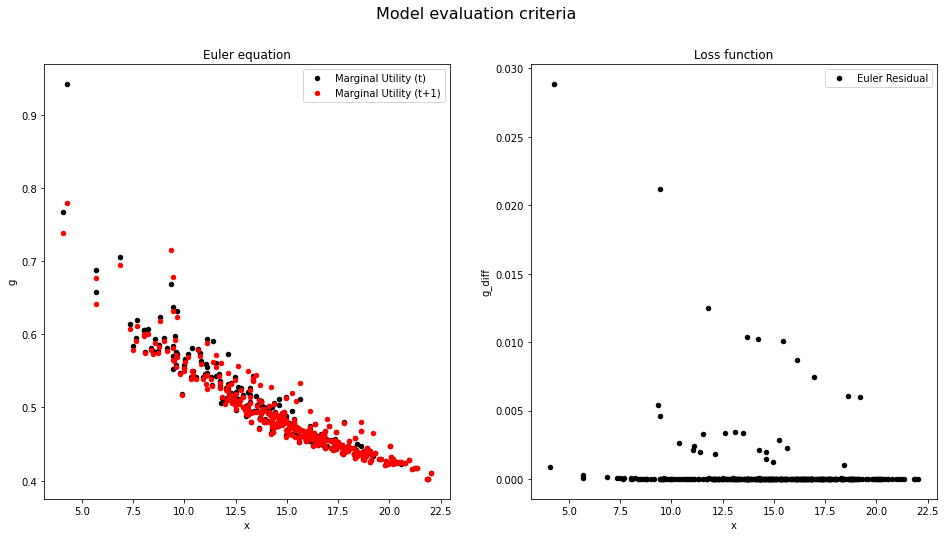

In [4]:
plot_loss(params, config, Xs, Zs, Es, key)

Here I plot the optimal consumption function that is implied by the neural network, as a function of the idiosyncratic state. Each different line color is a different aggregate state drawn from the ergodic distribution, and depicts the estimated optimal consumption of agent 1. Here we see the distinctive "kink" for consumption in the Krusell Smith model.

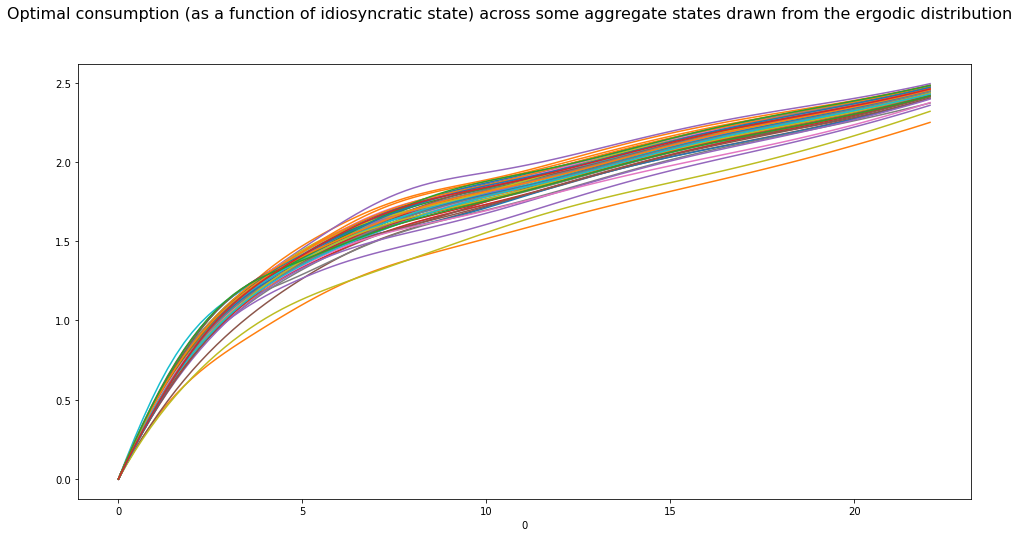

In [5]:
plot_consumption(params, config, Xs, Zs, Es)

The below figure shows the unconditional distribution of idiosyncratic wealth over many draws of the aggregate state.

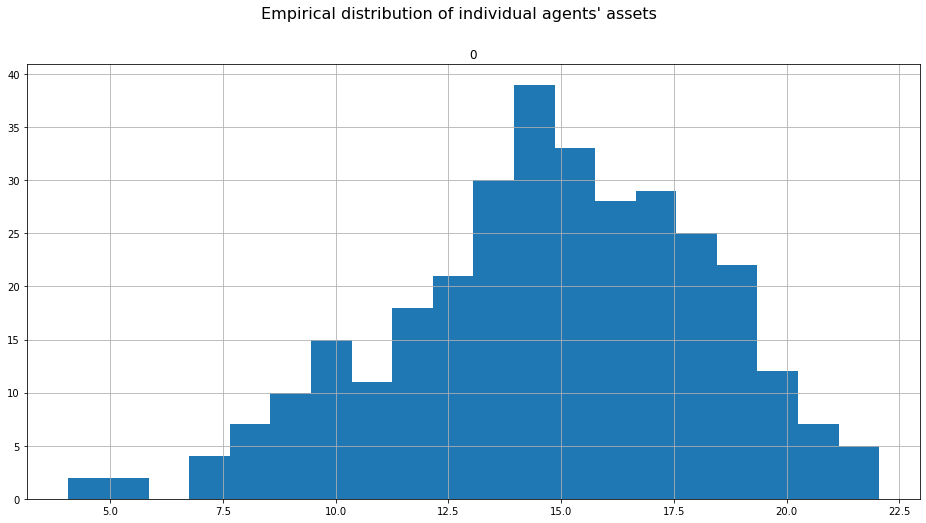

In [6]:
plot_wealth_dist(params, config, Xs, Zs, Es)

This figure shows a simulation of the model over $200$ periods. On the left the wealth of the $5$ agents in the model is plotted, and on the right the total capital/assets in the economy. Here we can see visually how the new states are drawn in step 2 of the learning procedure.

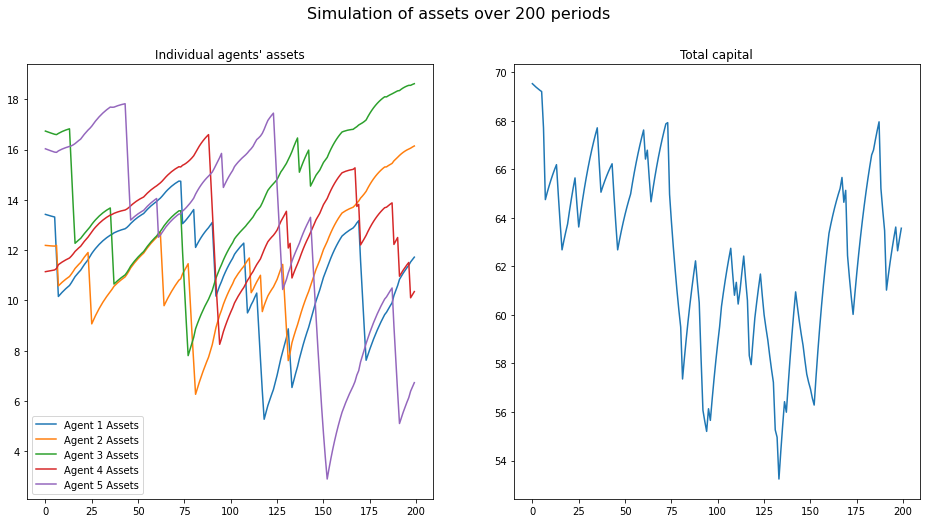

In [7]:
states = simulate_states(params, config, 200, Xs, Zs, Es, key)

Finally, this figure reproduces the famous "approximate aggregation" result of Krusell and Smith (1998). Here we can see that holding technology and employment fixed there is an essentially perfect intertemporal correlation in the aggregate capital stock, even though this was not assumed in the estimation procedure. I would interpret this as confirmation of Krusell and Smith's approximate aggregation assumption --- it seems to be a feature of the model even when not explicitly assumed. This also confirms the result of Young (2005) who shows that even if the agents are more sophisticated (in the sense that they consider higher moments that just the mean) this does not meaningfully change the equilibrium.

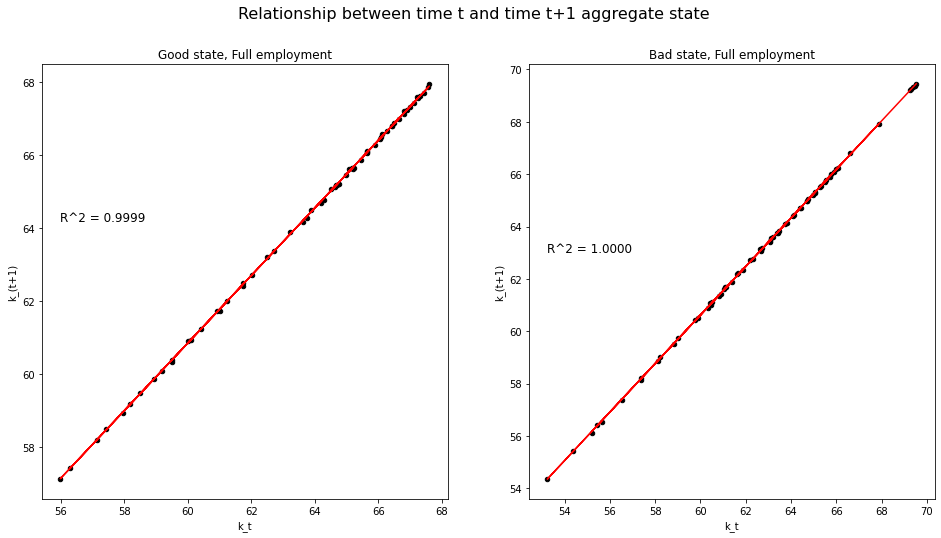

In [8]:
plot_state_transition(params, states)

### Extension

I now want to present a case in which the approximate aggregation result is broken. In order to achieve this I allow agents to have CES utility functions with heterogeneous preference parameters. In other words, the agents have different marginal propensity to consume / save, all else equal. Interestingly, Young (2005) considers a similar extension and finds that it does not cause approximate aggregation to break down. However, as we will see here, in my estimation it does.

Load the params, and simulate the model forwards into the ergodic set, as before.

In [3]:
SAVE_LOCATION = f'../models/ks_disc_model_prefhet_{k}_final.pkl'
params, Xs, Zs, Es, key = load_model(SAVE_LOCATION)

The agents' preference parameters are:

In [5]:
config['prefs']

DeviceArray([2.194757 , 1.3162477, 2.2748537, 2.3100939, 1.5107285], dtype=float32)

Here note the variation in the "smoothness" of the wealth of different agents, especially as compared to the baseline case. This reflects the agents' preference heterogeneity --- agents with a higher CES parameters (i.e. agent 4) are more risk and have a stronger tendency to smooth than agents with lower CES parameters (i.e. agent 2), however, they are also all subject to rather extreme unemployment shocks.

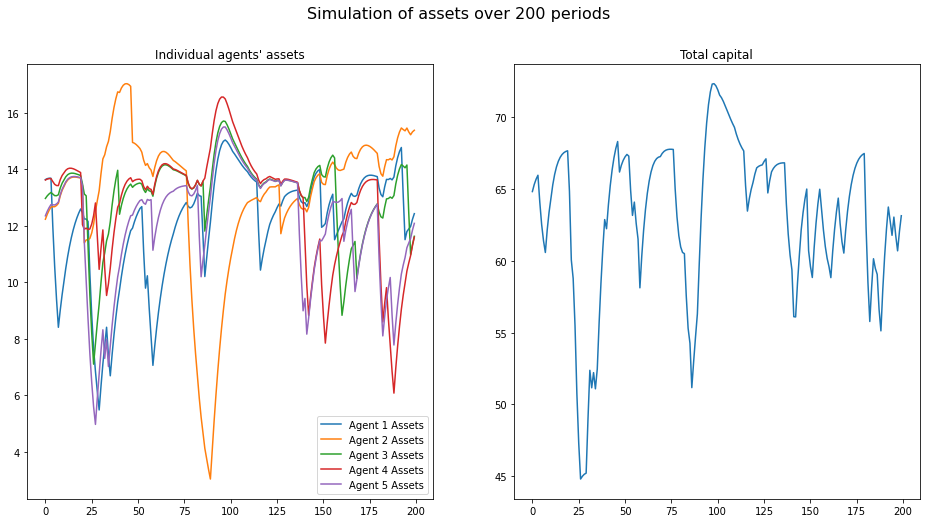

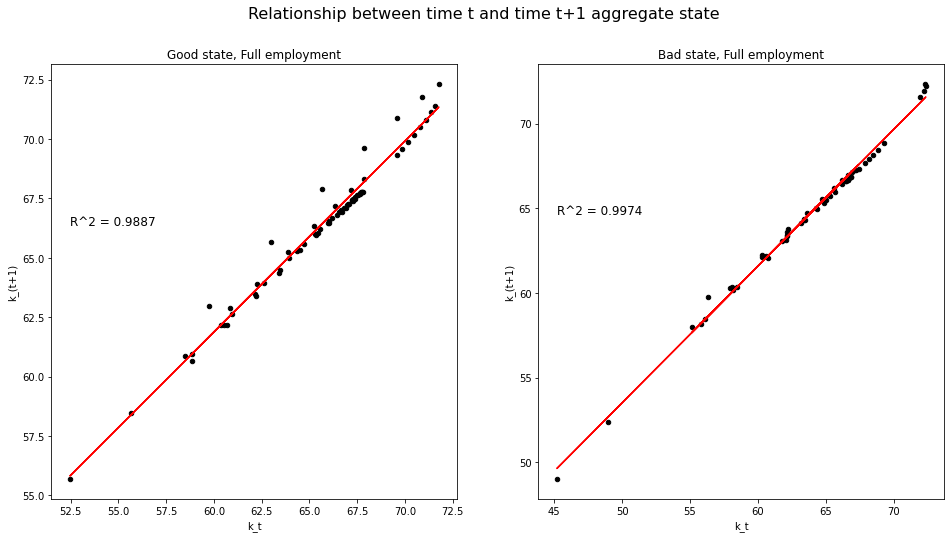

In [4]:
states = simulate_states(params, config, 200, Xs, Zs, Es, key)
plot_state_transition(params, states)

The correlation across time is still strong, but noticeably weaker than in the baseline case. To me (and I may be completely wrong) this seems to suggest that some of the extensions considered by Young (2005) were actually self-fullfilling equilibria, because the equilibrium here is estimated making no such assumption, and seems to show that such an assumption is in fact incorrect.

### Summary / Conclusion

This presentation has explored the concept of estimating macroeconomic models with machine-learning techniques. I think that this field is very current and has massive potential. I have shown here one example of how it might be used to shed new insight on old problems. And importantly, it will allow us to consider new problems that were previously considered intractable. 

In order to continue this research agenda I want to find some such new problems or applications that might be interesting to consider, so in particular this is what I would like to request feedback on. Also, I would like to know what metrics I can use to show that my solution estimates area actually correct --- other papers I have seen seem to just argue that because their loss / criterion is low the solution must be correct. But I don't find this to be very convincing, what if the loss / criterion is misspecified?

Any other feedback you have on this presentation is of course also very welcome!

### Citations

Azinovic, Marlon, Luca Gaegauf, and Simon Scheidegger. "Deep equilibrium nets." Available at SSRN 3393482 (2019).

Duarte, Victor. "Machine learning for continuous-time economics." Available at SSRN 3012602 (2018).

Krusell, Per, and Anthony A. Smith, Jr. "Income and wealth heterogeneity in the macroeconomy." Journal of political Economy 106.5 (1998): 867-896.

Maliar, Lilia, Serguei Maliar, and Pablo Winant. "Deep learning for solving dynamic economic models." Journal of Monetary Economics 122 (2021): 76-101.

Young, Eric. "Approximate aggregation." manuscript, University of Virginia (2005).